In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
df = pd.read_csv("../data/nigeria_houses_data.csv")
df.head()

,bedrooms,bathrooms,toilets,parking_space,title,town,state,price
0,6.0,5.0,5.0,4.0,Detached Duplex,Mabushi,Abuja,450000000.0
1,4.0,5.0,5.0,4.0,Terraced Duplexes,Katampe,Abuja,800000000.0
2,4.0,5.0,5.0,4.0,Detached Duplex,Lekki,Lagos,120000000.0
3,4.0,4.0,5.0,6.0,Detached Duplex,Ajah,Lagos,40000000.0
4,4.0,4.0,5.0,2.0,Semi Detached Duplex,Lekki,Lagos,75000000.0


In [3]:
df.isnull().sum()

bedrooms         0
bathrooms        0
toilets          0
parking_space    0
title            0
town             0
state            0
price            0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24326 entries, 0 to 24325
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       24326 non-null  float64
 1   bathrooms      24326 non-null  float64
 2   toilets        24326 non-null  float64
 3   parking_space  24326 non-null  float64
 4   title          24326 non-null  object 
 5   town           24326 non-null  object 
 6   state          24326 non-null  object 
 7   price          24326 non-null  float64
dtypes: float64(5), object(3)
memory usage: 1.5+ MB


<Axes: xlabel='price', ylabel='Count'>

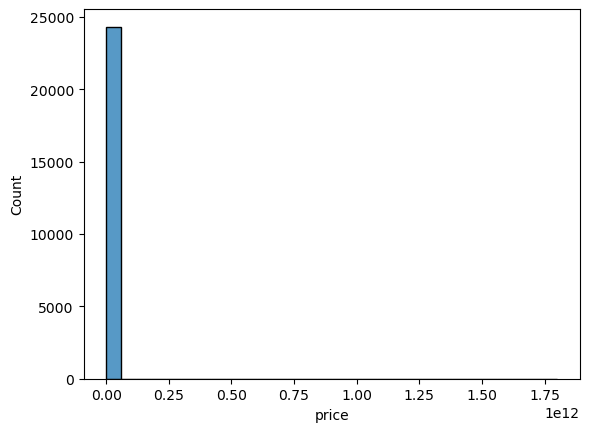

In [7]:
sns.histplot(df['price'], bins=30)

In [ ]:
df['state'].value_counts(ascending=False).head(10)

state
Lagos       18445
Abuja        3524
Ogun          637
Oyo           477
Rivers        444
Imo           246
Anambara      145
Enugu         128
Edo           100
Delta          63
Name: count, dtype: int64

<Axes: xlabel='bedrooms', ylabel='price'>

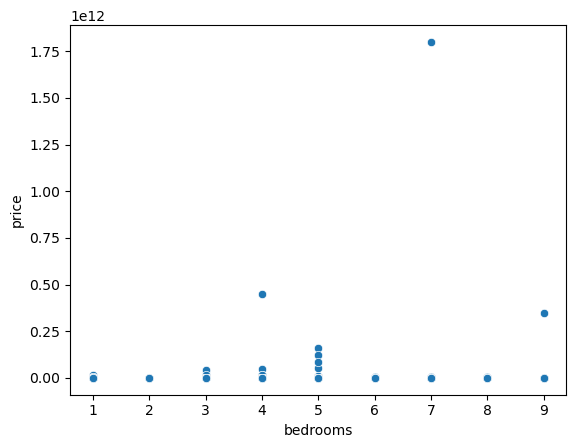

In [16]:
sns.scatterplot(data=df, x='bedrooms', y='price')